In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-xcyf0i9j
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-xcyf0i9j
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 2703d155c88d27bba9a1f465f5489a7947ffc313
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-1.0.10.dev0-py3-none-any.whl size=2325971 sha256=4153f584110fbd68831966a0dd8d21e27280c46e377ee7a8760d548886f5a10c
  Stored in directory: /tmp/pip-ephem-wheel-cache-62eqpyzz/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm
  Attempting uninstall: timm
    Found existing installation: timm 1.0.9
    Uninstalling timm-1.0.9:
      Successfully uninstalled timm-1.0.9


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torch
from tqdm.auto import tqdm
import numpy as np
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from torchvision import datasets


In [3]:
import seaborn as sns
import cv2
import matplotlib.pyplot as plt 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
IMAGE_SIZE=(224, 224)
batch_size=8
learning_rate = 5e-4
epochs=20

In [8]:
data_path = '/kaggle/input/brain-tumor-mri-images-44c/'
# data = datasets.ImageFolder(data_path,transform=transform)
# num_classes = len(trainset.classes)
# classes = trainset.classes

In [9]:
def main(train_data_path):
    
    """
    return training and testing dataframes including 2 columns image path and its label
    
    Args:
      train_data_path (string): string includes your train data path
      test_data_path (string): string includes your test data path
      note: data_path argument must contains your classes dirs
      
    Returns:
      train_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the training images and the label of each image
      test_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the testing images and the label of each image

    """
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):
    
    
    """
    return file paths list including all full image paths and label for each one
    
    Args:
      classes_list (list): list includes name of classes dirs
      dirs (string): the data path
      filepaths (list): empty list to fill with images paths later
      labels (list): empty list to fill with each image label later
      
    Returns:
      count (scalar):  number of images in your dataset
    """
    
    
    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    """
    return nothing, it fills the filepaths list with all the images paths and its labels
    
    Args:
      flist (list) : contains all the image names in certain class
      classes_list (list): list includes name of classes dirs
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      label (string): label for a specific image
      
    Returns:
      nothing
    """
    
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):
    
    """
    Return Dataframe with 2 columns contains each image path with its label
    
    Args:
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      
    Returns:
      train_df (DataFrame):  Dataframe with 2 columns contains each image path with its label
    """
    
    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

def merge_classes(data):
    """
    Merge classes with similar names
    
    Args:
      labels (list): list of image labels
      
    Returns:
      merged_labels (list): list of merged image labels
    """
    # Define mappings of classes to be merged
    class_mappings_reversed = {
    'Astrocitoma T1': 'Astrocitoma',
    'Astrocitoma T1C+': 'Astrocitoma',
    'Astrocitoma T2': 'Astrocitoma',
    'Carcinoma T1': 'Carcinoma',
    'Carcinoma T1C+': 'Carcinoma',
    'Carcinoma T2': 'Carcinoma',
    'Ependimoma T1': 'Ependimoma',
    'Ependimoma T1C+': 'Ependimoma',
    'Ependimoma T2': 'Ependimoma',
    'Ganglioglioma T1': 'Ganglioglioma',
    'Ganglioglioma T1C+': 'Ganglioglioma',
    'Ganglioglioma T2': 'Ganglioglioma',
    'Germinoma T1': 'Germinoma',
    'Germinoma T1C+': 'Germinoma',
    'Germinoma T2': 'Germinoma',
    'Glioblastoma T1': 'Glioblastoma',
    'Glioblastoma T1C+': 'Glioblastoma',
    'Glioblastoma T2': 'Glioblastoma',
    'Granuloma T1': 'Granuloma',
    'Granuloma T1C+': 'Granuloma',
    'Granuloma T2': 'Granuloma',
    'Meduloblastoma T1': 'Meduloblastoma',
    'Meduloblastoma T1C+': 'Meduloblastoma',
    'Meduloblastoma T2': 'Meduloblastoma',
    'Meningioma T1': 'Meningioma',
    'Meningioma T1C+': 'Meningioma',
    'Meningioma T2': 'Meningioma',
    'Neurocitoma T1': 'Neurocitoma',
    'Neurocitoma T1C+': 'Neurocitoma',
    'Neurocitoma T2': 'Neurocitoma',
    'Oligodendroglioma T1': 'Oligodendroglioma',
    'Oligodendroglioma T1C+': 'Oligodendroglioma',
    'Oligodendroglioma T2': 'Oligodendroglioma',
    'Papiloma T1': 'Papiloma',
    'Papiloma T1C+': 'Papiloma',
    'Papiloma T2': 'Papiloma',
    'Schwannoma T1': 'Schwannoma',
    'Schwannoma T1C+': 'Schwannoma',
    'Schwannoma T2': 'Schwannoma',
    'Tuberculoma T1': 'Tuberculoma',
    'Tuberculoma T1C+': 'Tuberculoma',
    'Tuberculoma T2': 'Tuberculoma',
    '_NORMAL T1': 'NORMAL',
    '_NORMAL T2': 'NORMAL'
}

    for i in data.index:
        data["label"].at[i] = class_mappings_reversed[data["label"].at[i]]
        
    return data

In [10]:
data_dir = '/kaggle/input/brain-tumor-mri-images-44c/'

data_df = main(data_dir)


In [11]:
data_df = merge_classes(data_df)


In [27]:
classes = data_df["label"].unique()

In [13]:
data_df

,image_path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
1,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
2,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
4,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
...,...,...
4474,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,NORMAL
4475,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,NORMAL
4476,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,NORMAL
4477,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,NORMAL


In [14]:

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(dataframe['label'].unique())}  # Mapping from label to index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get the image path
        image = Image.open(img_path)  # Open the image

        # Convert grayscale images to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = self.dataframe.iloc[idx, 1]  # Get the label
        label_index = self.label_map[label]  # Convert label to index
        
        if self.transform:
            image = self.transform(image)  # Apply transformations if any

        return image, label_index  # Return image and its index


In [15]:
# ds = ImageFolder(data_path, transform = transform)
ds = CustomImageDataset(dataframe=data_df, transform=transform)


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, ConcatDataset

labels = [label for _, label in ds]

sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(ds, train_indices_1)
test_data = Subset(ds, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)

In [17]:
BATCH_SIZE = 8
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [18]:
num_classes = 15

# Create the model
model = timm.create_model('pit_ti_224', pretrained=True)

# Modify the model's output head
model.head = torch.nn.Linear(model.head.in_features, 15)

# Move the model to the specified device
model.to(device)

# Print the model summary
summary(model, (3, 224, 224))  #

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 15]                   46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

LR = 0.0005
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)


In [22]:
total_epochs = 25

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
#     scheduler.step()

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 359/359 [00:32<00:00, 11.16it/s]


Metrics - loss: 2.4591, accuracy: 0.1950, precision: 0.1111, recall: 0.1950, f1_score: 0.1289, specificity: 0.1806, sensitivity: 0.8505, mcc: 0.0459, auc: 0.5561


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.57it/s]


Metrics - loss: 2.4360, accuracy: 0.1953, precision: 0.0381, recall: 0.1953, f1_score: 0.0638, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6366


Training Model - Epoch [2/25]: 100%|██████████| 359/359 [00:31<00:00, 11.25it/s]


Metrics - loss: 2.3905, accuracy: 0.2066, precision: 0.1380, recall: 0.2066, f1_score: 0.1394, specificity: 0.1968, sensitivity: 0.8774, mcc: 0.0618, auc: 0.6138


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.17it/s]


Metrics - loss: 2.3149, accuracy: 0.2469, precision: 0.0981, recall: 0.2469, f1_score: 0.1265, specificity: 0.0000, sensitivity: 0.9904, mcc: 0.1202, auc: 0.7017


Training Model - Epoch [3/25]: 100%|██████████| 359/359 [00:31<00:00, 11.23it/s]


Metrics - loss: 2.3125, accuracy: 0.2352, precision: 0.1608, recall: 0.2352, f1_score: 0.1697, specificity: 0.2318, sensitivity: 0.8473, mcc: 0.1054, auc: 0.6584


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.60it/s]


Metrics - loss: 2.2447, accuracy: 0.2789, precision: 0.2047, recall: 0.2789, f1_score: 0.1634, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1743, auc: 0.7298


Training Model - Epoch [4/25]: 100%|██████████| 359/359 [00:31<00:00, 11.35it/s]


Metrics - loss: 2.2663, accuracy: 0.2404, precision: 0.1890, recall: 0.2404, f1_score: 0.1812, specificity: 0.1941, sensitivity: 0.8713, mcc: 0.1140, auc: 0.6795


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.60it/s]


Metrics - loss: 2.1983, accuracy: 0.3040, precision: 0.2867, recall: 0.3040, f1_score: 0.1974, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2084, auc: 0.7295


Training Model - Epoch [5/25]: 100%|██████████| 359/359 [00:31<00:00, 11.38it/s]


Metrics - loss: 2.1708, accuracy: 0.2844, precision: 0.2404, recall: 0.2844, f1_score: 0.2374, specificity: 0.2534, sensitivity: 0.8754, mcc: 0.1744, auc: 0.7147


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.84it/s]


Metrics - loss: 2.0872, accuracy: 0.3054, precision: 0.2507, recall: 0.3054, f1_score: 0.2386, specificity: 0.0538, sensitivity: 0.9904, mcc: 0.2013, auc: 0.7556


Training Model - Epoch [6/25]: 100%|██████████| 359/359 [00:32<00:00, 11.15it/s]


Metrics - loss: 2.1379, accuracy: 0.2931, precision: 0.2521, recall: 0.2931, f1_score: 0.2495, specificity: 0.2102, sensitivity: 0.8914, mcc: 0.1856, auc: 0.7220


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.11it/s]


Metrics - loss: 2.2826, accuracy: 0.2608, precision: 0.2389, recall: 0.2608, f1_score: 0.1844, specificity: 0.0108, sensitivity: 0.9984, mcc: 0.1475, auc: 0.7225


Training Model - Epoch [7/25]: 100%|██████████| 359/359 [00:30<00:00, 11.59it/s]


Metrics - loss: 2.0883, accuracy: 0.3029, precision: 0.2714, recall: 0.3029, f1_score: 0.2668, specificity: 0.2426, sensitivity: 0.8822, mcc: 0.1989, auc: 0.7457


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.82it/s]


Metrics - loss: 2.0117, accuracy: 0.3556, precision: 0.2943, recall: 0.3556, f1_score: 0.2798, specificity: 0.0538, sensitivity: 0.9920, mcc: 0.2688, auc: 0.7788


Training Model - Epoch [8/25]: 100%|██████████| 359/359 [00:31<00:00, 11.53it/s]


Metrics - loss: 1.9699, accuracy: 0.3419, precision: 0.3096, recall: 0.3419, f1_score: 0.3095, specificity: 0.2695, sensitivity: 0.8854, mcc: 0.2470, auc: 0.7809


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.07it/s]


Metrics - loss: 1.9345, accuracy: 0.3835, precision: 0.4060, recall: 0.3835, f1_score: 0.3302, specificity: 0.0538, sensitivity: 0.9808, mcc: 0.3018, auc: 0.7959


Training Model - Epoch [9/25]: 100%|██████████| 359/359 [00:30<00:00, 11.63it/s]


Metrics - loss: 1.8812, accuracy: 0.3733, precision: 0.3491, recall: 0.3733, f1_score: 0.3449, specificity: 0.2049, sensitivity: 0.8962, mcc: 0.2859, auc: 0.8012


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.74it/s]


Metrics - loss: 1.7767, accuracy: 0.4198, precision: 0.3947, recall: 0.4198, f1_score: 0.3552, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.3445, auc: 0.8354


Training Model - Epoch [10/25]: 100%|██████████| 359/359 [00:30<00:00, 11.68it/s]


Metrics - loss: 1.7752, accuracy: 0.4156, precision: 0.4006, recall: 0.4156, f1_score: 0.3922, specificity: 0.2507, sensitivity: 0.9066, mcc: 0.3362, auc: 0.8290


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.85it/s]


Metrics - loss: 1.7188, accuracy: 0.4505, precision: 0.4551, recall: 0.4505, f1_score: 0.3935, specificity: 0.0215, sensitivity: 0.9936, mcc: 0.3857, auc: 0.8513


Training Model - Epoch [11/25]: 100%|██████████| 359/359 [00:31<00:00, 11.45it/s]


Metrics - loss: 1.6982, accuracy: 0.4191, precision: 0.3989, recall: 0.4191, f1_score: 0.3956, specificity: 0.2345, sensitivity: 0.9030, mcc: 0.3409, auc: 0.8472


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.05it/s]


Metrics - loss: 1.6141, accuracy: 0.4519, precision: 0.4635, recall: 0.4519, f1_score: 0.4118, specificity: 0.0968, sensitivity: 0.9744, mcc: 0.3825, auc: 0.8733


Training Model - Epoch [12/25]: 100%|██████████| 359/359 [00:31<00:00, 11.54it/s]


Metrics - loss: 1.5533, accuracy: 0.4780, precision: 0.4664, recall: 0.4780, f1_score: 0.4572, specificity: 0.2534, sensitivity: 0.9114, mcc: 0.4101, auc: 0.8742


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.14it/s]


Metrics - loss: 1.6271, accuracy: 0.4505, precision: 0.4900, recall: 0.4505, f1_score: 0.4050, specificity: 0.0538, sensitivity: 0.9920, mcc: 0.3858, auc: 0.8791


Training Model - Epoch [13/25]: 100%|██████████| 359/359 [00:31<00:00, 11.57it/s]


Metrics - loss: 1.5840, accuracy: 0.4669, precision: 0.4627, recall: 0.4669, f1_score: 0.4459, specificity: 0.2884, sensitivity: 0.9194, mcc: 0.3973, auc: 0.8718


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 19.06it/s]


Metrics - loss: 1.6042, accuracy: 0.5132, precision: 0.4981, recall: 0.5132, f1_score: 0.4835, specificity: 0.1935, sensitivity: 0.9631, mcc: 0.4538, auc: 0.8750


Training Model - Epoch [14/25]: 100%|██████████| 359/359 [00:30<00:00, 11.60it/s]


Metrics - loss: 1.4582, accuracy: 0.5084, precision: 0.4970, recall: 0.5084, f1_score: 0.4922, specificity: 0.3423, sensitivity: 0.9150, mcc: 0.4455, auc: 0.8963


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.23it/s]


Metrics - loss: 1.4234, accuracy: 0.5342, precision: 0.5670, recall: 0.5342, f1_score: 0.5127, specificity: 0.3011, sensitivity: 0.9327, mcc: 0.4752, auc: 0.9098


Training Model - Epoch [15/25]: 100%|██████████| 359/359 [00:30<00:00, 11.82it/s]


Metrics - loss: 1.2981, accuracy: 0.5583, precision: 0.5484, recall: 0.5583, f1_score: 0.5426, specificity: 0.3801, sensitivity: 0.9166, mcc: 0.5023, auc: 0.9181


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.95it/s]


Metrics - loss: 1.4834, accuracy: 0.5216, precision: 0.5444, recall: 0.5216, f1_score: 0.5016, specificity: 0.3656, sensitivity: 0.9535, mcc: 0.4624, auc: 0.9046


Training Model - Epoch [16/25]: 100%|██████████| 359/359 [00:30<00:00, 11.74it/s]


Metrics - loss: 1.3512, accuracy: 0.5468, precision: 0.5424, recall: 0.5468, f1_score: 0.5349, specificity: 0.4097, sensitivity: 0.9130, mcc: 0.4892, auc: 0.9106


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.74it/s]


Metrics - loss: 1.2637, accuracy: 0.5886, precision: 0.5921, recall: 0.5886, f1_score: 0.5634, specificity: 0.3011, sensitivity: 0.9551, mcc: 0.5389, auc: 0.9314


Training Model - Epoch [17/25]: 100%|██████████| 359/359 [00:30<00:00, 11.72it/s]


Metrics - loss: 1.2124, accuracy: 0.6029, precision: 0.5985, recall: 0.6029, f1_score: 0.5941, specificity: 0.5013, sensitivity: 0.9222, mcc: 0.5533, auc: 0.9313


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s]


Metrics - loss: 1.3626, accuracy: 0.5649, precision: 0.6043, recall: 0.5649, f1_score: 0.5449, specificity: 0.2043, sensitivity: 0.9679, mcc: 0.5131, auc: 0.9226


Training Model - Epoch [18/25]: 100%|██████████| 359/359 [00:30<00:00, 11.65it/s]


Metrics - loss: 1.1644, accuracy: 0.6096, precision: 0.6084, recall: 0.6096, f1_score: 0.6028, specificity: 0.5040, sensitivity: 0.9230, mcc: 0.5611, auc: 0.9357


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.30it/s]


Metrics - loss: 1.3595, accuracy: 0.5565, precision: 0.5777, recall: 0.5565, f1_score: 0.5422, specificity: 0.2796, sensitivity: 0.9712, mcc: 0.5072, auc: 0.9212


Training Model - Epoch [19/25]: 100%|██████████| 359/359 [00:31<00:00, 11.49it/s]


Metrics - loss: 1.1010, accuracy: 0.6347, precision: 0.6299, recall: 0.6347, f1_score: 0.6279, specificity: 0.5445, sensitivity: 0.9246, mcc: 0.5896, auc: 0.9426


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.69it/s]


Metrics - loss: 1.3731, accuracy: 0.5593, precision: 0.5835, recall: 0.5593, f1_score: 0.5480, specificity: 0.3011, sensitivity: 0.9663, mcc: 0.5080, auc: 0.9242


Training Model - Epoch [20/25]: 100%|██████████| 359/359 [00:30<00:00, 11.58it/s]


Metrics - loss: 1.0582, accuracy: 0.6493, precision: 0.6437, recall: 0.6493, f1_score: 0.6422, specificity: 0.5660, sensitivity: 0.9263, mcc: 0.6065, auc: 0.9466


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.36it/s]


Metrics - loss: 1.1501, accuracy: 0.6332, precision: 0.6470, recall: 0.6332, f1_score: 0.6194, specificity: 0.3763, sensitivity: 0.9519, mcc: 0.5912, auc: 0.9458


Training Model - Epoch [21/25]: 100%|██████████| 359/359 [00:31<00:00, 11.53it/s]


Metrics - loss: 0.9710, accuracy: 0.6797, precision: 0.6761, recall: 0.6797, f1_score: 0.6744, specificity: 0.5849, sensitivity: 0.9391, mcc: 0.6405, auc: 0.9544


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.37it/s]


Metrics - loss: 1.1363, accuracy: 0.6499, precision: 0.6726, recall: 0.6499, f1_score: 0.6454, specificity: 0.4516, sensitivity: 0.9583, mcc: 0.6092, auc: 0.9468


Training Model - Epoch [22/25]: 100%|██████████| 359/359 [00:32<00:00, 11.22it/s]


Metrics - loss: 0.9187, accuracy: 0.6832, precision: 0.6804, recall: 0.6832, f1_score: 0.6796, specificity: 0.6011, sensitivity: 0.9387, mcc: 0.6449, auc: 0.9602


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.32it/s]


Metrics - loss: 1.1560, accuracy: 0.6095, precision: 0.6347, recall: 0.6095, f1_score: 0.5999, specificity: 0.5161, sensitivity: 0.9295, mcc: 0.5628, auc: 0.9501


Training Model - Epoch [23/25]: 100%|██████████| 359/359 [00:31<00:00, 11.47it/s]


Metrics - loss: 0.8324, accuracy: 0.7174, precision: 0.7155, recall: 0.7174, f1_score: 0.7145, specificity: 0.6361, sensitivity: 0.9451, mcc: 0.6833, auc: 0.9679


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.15it/s]


Metrics - loss: 1.1385, accuracy: 0.6639, precision: 0.6995, recall: 0.6639, f1_score: 0.6632, specificity: 0.4839, sensitivity: 0.9679, mcc: 0.6273, auc: 0.9530


Training Model - Epoch [24/25]: 100%|██████████| 359/359 [00:31<00:00, 11.46it/s]


Metrics - loss: 0.8235, accuracy: 0.7240, precision: 0.7230, recall: 0.7240, f1_score: 0.7218, specificity: 0.6631, sensitivity: 0.9447, mcc: 0.6909, auc: 0.9693


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.91it/s]


Metrics - loss: 1.1581, accuracy: 0.6513, precision: 0.6764, recall: 0.6513, f1_score: 0.6435, specificity: 0.4516, sensitivity: 0.9567, mcc: 0.6102, auc: 0.9510


Training Model - Epoch [25/25]: 100%|██████████| 359/359 [00:32<00:00, 11.19it/s]


Metrics - loss: 0.7861, accuracy: 0.7390, precision: 0.7360, recall: 0.7390, f1_score: 0.7360, specificity: 0.6361, sensitivity: 0.9467, mcc: 0.7076, auc: 0.9697


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.00it/s]


Metrics - loss: 1.1985, accuracy: 0.6179, precision: 0.6293, recall: 0.6179, f1_score: 0.6068, specificity: 0.4624, sensitivity: 0.9519, mcc: 0.5739, auc: 0.9468
Total Training Time: 0:13:02.200595
Total Validation Time: 0:02:07.614706
Average Training Time per Epoch: 0:00:31.288024
Average Validation Time per Epoch: 0:00:05.104588


In [23]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 112/112 [00:07<00:00, 14.53it/s]

Metrics - loss: 1.2402, accuracy: 0.6350, precision: 0.6429, recall: 0.6350, f1_score: 0.6240, specificity: 0.4310, sensitivity: 0.9487, mcc: 0.5923, auc: 0.9145


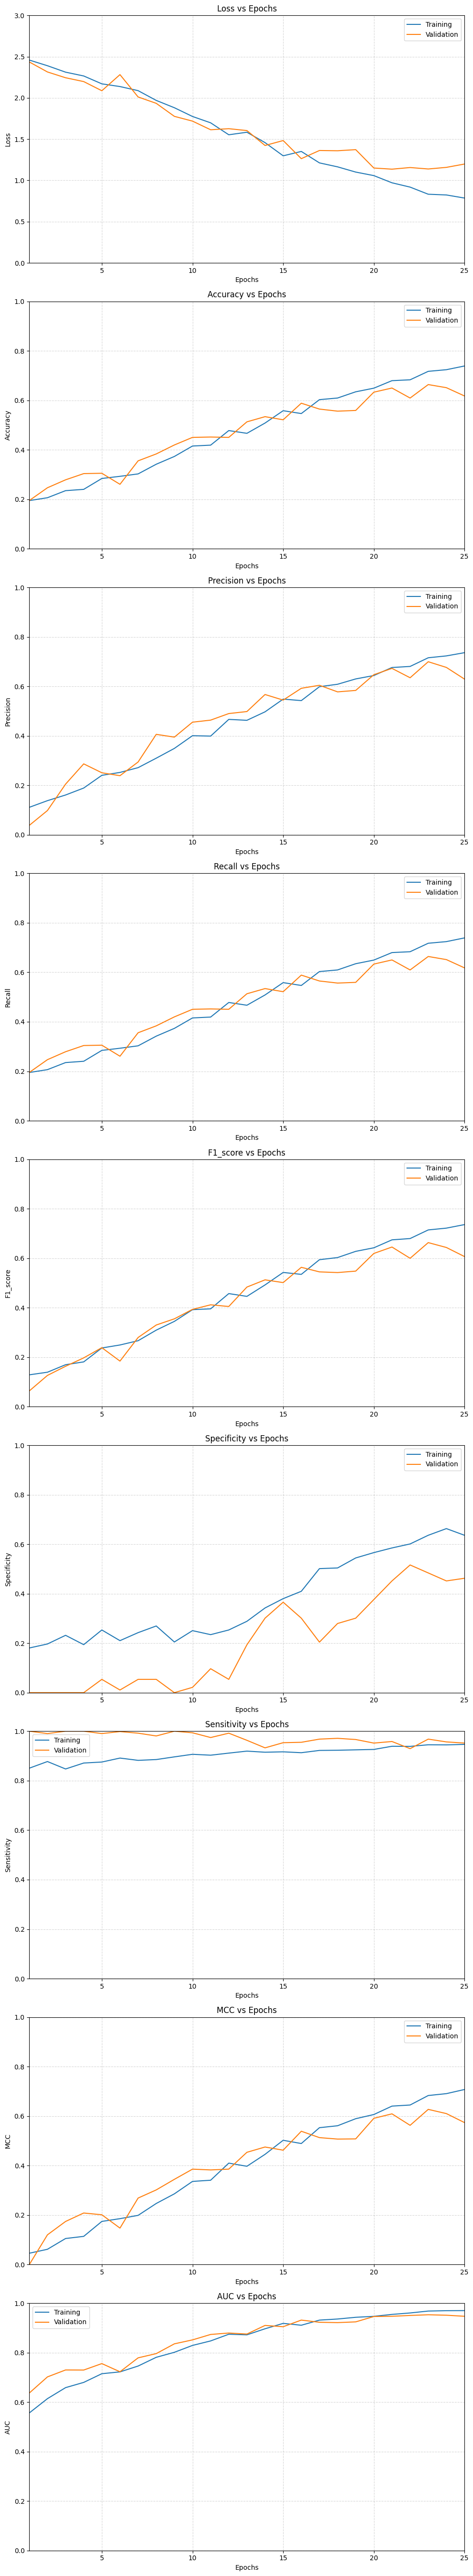

In [24]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

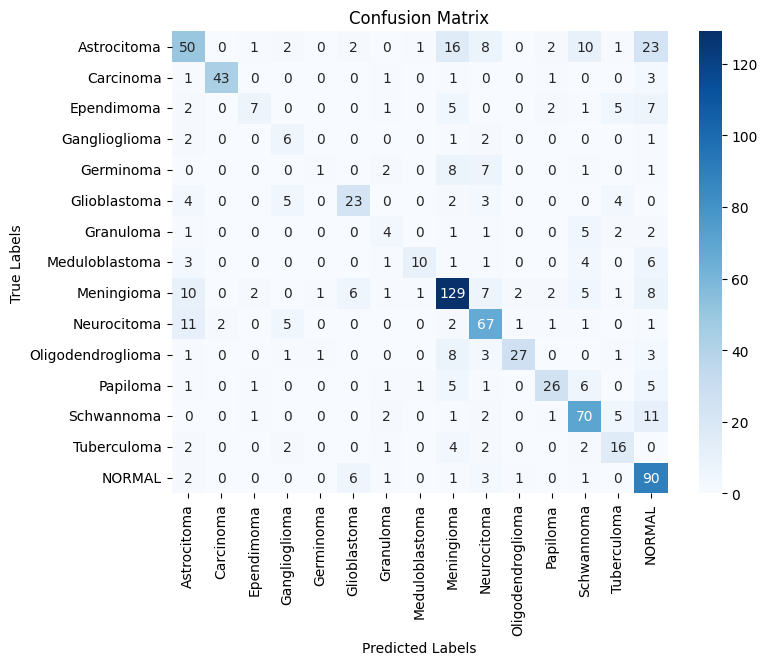

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have test_labels (targets) and test_predictions (predicted labels)
# Convert the softmax/logit outputs to predicted labels by taking the argmax
# if your output is a softmax over classes
predicted_labels = np.argmax(all_predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, predicted_labels)

# Plot confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
